<a href="https://colab.research.google.com/github/Ankit2058/Fruit-Classification/blob/main/Software/Custom_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have two dataset of rooten and fresh banana  
First google drive is mounted to access the data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I got into this habit of inserting all the imports code in single code snippet

In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

Now i save the path to the data in two variables  
I will retrive data in the drive via these links

In [3]:
#Path to folders with data in drive
F_Banana = "/content/drive/MyDrive/Major_Project/F_Banana"
S_Banana = "/content/drive/MyDrive/Major_Project/S_Banana"

This code snippet retrives data from drive

<PIL.Image.Image image mode=RGB size=256x256 at 0x7AAC612ECF70>


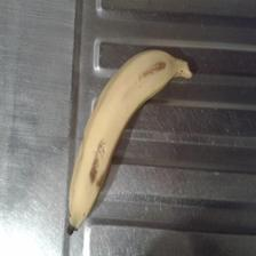

732.jpg


In [4]:
file_list =os.listdir(F_Banana) #file names in F-Banana are listed in file_list
file_name=file_list[0]
image_path=os.path.join(F_Banana, file_name)#full path to a particular file
image = Image.open(image_path).convert('RGB')  # Converting to RGB
image = image.resize((256, 256))#resizing the image
print(image)
display(image)
print(file_name)

So lets give a brief idea of whats been done till now an what things will be done in the future.

**Tillnow** we have able to retrive data from the drive link
we have a list of links of data which can be later used for training pupose

**Whats ahead?**
We need to design a dataloader which will load data onto the model
We need to make a model
Then use the model to predict the image

In [5]:
# Define labels
labels = {'fresh': 0, 'rotten': 1}

# Load images and assign labels
data = []
for label, folder in [('fresh', F_Banana), ('rotten', S_Banana)]:
    for file_name in os.listdir(folder):
        img_path = os.path.join(folder, file_name)
        if file_name.endswith(('.jpg', '.png', '.jpeg')):  # Filter image files
            data.append((img_path, labels[label]))

# Split into train and test datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define a transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a standard size
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Custom Dataset class
class BananaDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
train_dataset = BananaDataset(train_data, transform=transform)
test_dataset = BananaDataset(test_data, transform=transform)

# Convert to DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example: Checking one batch
for images, labels in train_loader:
    print(f"Batch of images: {images.shape}")  # Should be [batch_size, 3, 224, 224]
    print(f"Batch of labels: {labels}")
    break

Batch of images: torch.Size([32, 3, 224, 224])
Batch of labels: tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0])


In [10]:
print(train_dataset)

In [12]:
print(f"we have {len(train_data)} data for training and {len(test_data)} for testing")
#we have a huge dataset and we cant inset it directly into the

we have 480 data for training and 120 for testing


its an matrics of numbers.

In [20]:
#Working with nn we first need to define or import the model we will be training upon
#lets just define it!
class neural_network(torch.nn.Module):
  #we define the skeleton of our model using class and instante an model as an object, here you will find _init_(constructor) which instanciate every model with attributes flatten and linear_relu_stack that hold the object of the instantiated class
  def __init__(self):
    super(neural_network,self).__init__()
    self.flatten=torch.nn.Flatten() #self.flatten is instanciated from torch.nn.Flatten
    #self is used to bring the defined attribute,function out of the  _init_ funtion scope
    #Anything defined with "self"prefix has its scope across the class
    self.linear_relu_stack=torch.nn.Sequential(
        nn.Linear(224*224*3,4096),
        nn.ReLU(),
        nn.Linear(4096,1024),
        nn.ReLU(),
        nn.Linear(1024,256),
        nn.ReLU(),
        nn.Linear(256,2)
    )
    #Then we defin a forward funtion to propagate input data throught the model
  def forward(self,x):
     x = self.flatten(x)
     logits = self.linear_relu_stack(x)
     return logits

In [21]:
#now lets define a model as an instane of the neural_network class
model=neural_network();

In [17]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epoch=10
batch_size=64

In [18]:
#so we have build up all of our arsenal required for the final job of training our small model and test how well it did its job
#now lets train our model
#here we define the tarining_looop which takes dataloader which feeds data in batches, training_loop further takes model itself, loss function and optimizer.
#the sole purpose here is to calculate the loss using loss_fn on the ouput of the model when inputed with dataloader input and optimize model parameter using the optimizer specified in the argument
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
      #In this loop batch hold the batch value given by dataloader and X and y values yet again from dataloader
      #X dosent hold a single image rather it holds batch of images
      #We loop through every batch of image
      #And perform following computation, every batch
        # Compute prediction and loss
        pred = model(X)
        #Output of batch of images
        loss = loss_fn(pred, y)
        #single loss value if computed from the batch of output

        # Backpropagation
        loss.backward()
        #we propgate the loss back to each layers for gradient computation
        optimizer.step()
        #Then we optimize the model parameter
        optimizer.zero_grad()
        #Everytime we backpropagate, gradients value gets stored for optimization purposes, but if not set to zero the gradient of next batch will be accumulated
        #now if you want to optimize the model after every 5 batches of data then do zero-grad after every 5 batches, till then the gradient of each of those 5 batches will be accumulated
        #but for now we want to optimize the model after each batch so we need to zero-grad after every batch

        if batch % 100 == 0:
            print(batch)
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [22]:
#now all we need to do is train and test the model for the number of times(epochs) we want
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("DONE!")

Epoch 1
-------------------------------
0
loss: 0.696598  [   32/  480]
Test Error: 
 Accuracy: 48.3%, Avg loss: 0.699182 

DONE!


In [ ]:
# directly loading the model parameters if you have already trained the model
model.load_state_dict(torch.load("model.pth"))
model.eval()  # Set the model to evaluation mode (important for inference)

In [ ]:

#here i am checking if the predicted class matches with the actual class
for i in range(5):
  testing=test_images[i]
  print(f"predicted value of the image is {model(testing).argmax(1)}") #this prints the actual class of the test data
  #how it works: model(training) gives the matrices of ouput, argmax(1) gives the index of the value within the output with the highest value(highest value in the output denote the predicted class)
  plotting(test_images[i],test_labels[i])
  #plotting function shows the image in the data along with label


NameError: name 'test_images' is not defined